# REINFORCE in lasagne

Just like we did before for q-learning, this time we'll design a lasagne network to learn `CartPole-v0` via policy gradient (REINFORCE).

Most of the code in this notebook is taken from approximate qlearning, so you'll find it more or less familiar and even simpler.

__Frameworks__ - we'll accept this homework in any deep learning framework. For example, it translates to TensorFlow almost line-to-line. However, we recommend you to stick to theano/lasagne unless you're certain about your skills in the framework of your choice.

In [1]:
%env THEANO_FLAGS='floatX=float32'
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

env: THEANO_FLAGS='floatX=float32'
env: DISPLAY=:1


'bash' is not recognized as an internal or external command,
operable program or batch file.


[2017-12-17 19:52:59,730] Making new env: CartPole-v0


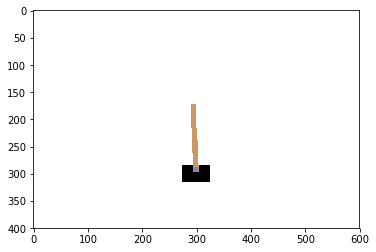

In [2]:
import gym
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make("CartPole-v0")
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render("rgb_array"))

# Building the network for REINFORCE

For REINFORCE algorithm, we'll need a model that predicts action probabilities given states.

In [3]:
import theano
import theano.tensor as T

#create input variables. We'll support multiple states at once

states = T.matrix("states[batch,units]")
actions = T.ivector("action_ids[batch]")
cumulative_rewards = T.vector("G[batch] = r + gamma*r' + gamma^2*r'' + ...")

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
[2017-12-17 20:20:19,643] g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
[2017-12-17 20:20:19,653] g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.


In [12]:
import lasagne
from lasagne.layers import *

#input layer
l_states = InputLayer((None,)+state_dim,input_var=states)

nn = DenseLayer(l_states, 100, nonlinearity=lasagne.nonlinearities.elu)
nn2 = DenseLayer(nn, 100, nonlinearity=lasagne.nonlinearities.elu)

#output layer
#this time we need to predict action probabilities,
#so make sure your nonlinearity forces p>0 and sum_p = 1
l_action_probas = DenseLayer(nn2,
                             num_units=n_actions,
                             nonlinearity=lasagne.nonlinearities.softmax )

#### Predict function

In [34]:
#get probabilities of actions
predicted_probas = get_output(l_action_probas)

#predict action probability given state
#if you use float32, set allow_input_downcast=True
predict_proba = theano.function([states], predicted_probas,  allow_input_downcast=True)


#### Loss function and updates

We now need to define objective and update over policy gradient.

Our objective function is

$$ J \approx  { 1 \over N } \sum  _{s_i,a_i} \pi_\theta (a_i | s_i) \cdot G(s_i,a_i) $$


Following the REINFORCE algorithm, we can define our objective as follows: 

$$ \hat J \approx { 1 \over N } \sum  _{s_i,a_i} log \pi_\theta (a_i | s_i) \cdot G(s_i,a_i) $$

When you compute gradient of that function over network weights $ \theta $, it will become exactly the policy gradient.


In [35]:
#select probabilities for chosen actions, pi(a_i|s_i)
predicted_probas_for_actions = predicted_probas[T.arange(actions.shape[0]),actions]

In [36]:
#REINFORCE objective function
J = T.mean(T.log(predicted_probas_for_actions)*cumulative_rewards)


In [ ]:
neg_H = (predicted_probas*T.log(predicted_probas)).sum(-1).mean()

In [37]:
J.ndim

0

In [38]:
#all network weights
all_weights = get_all_params(l_action_probas)

#weight updates. maximize J = minimize -J
updates = lasagne.updates.sgd(-J + 0.01*neg_H,all_weights,learning_rate=0.01)

In [39]:
train_step = theano.function([states,actions,cumulative_rewards],updates=updates,
                             allow_input_downcast=True)

### Computing cumulative rewards

In [40]:
def get_cumulative_rewards(rewards, #rewards at each step
                           gamma = 0.99 #discount for reward
                           ):
    """
    take a list of immediate rewards r(s,a) for the whole session 
    compute cumulative returns (a.k.a. G(s,a) in Sutton '16)
    G_t = r_t + gamma*r_{t+1} + gamma^2*r_{t+2} + ...
    
    The simple way to compute cumulative rewards is to iterate from last to first time tick
    and compute G_t = r_t + gamma*G_{t+1} recurrently
    
    You must return an array/list of cumulative rewards with as many elements as in the initial rewards.
    """
    
    R=[0]
    for i in range(len(rewards)):
        R.append(rewards[-i-1] + gamma*R[-1])
        
    return R[::-1][:-1]
    
    
    

In [41]:
assert len(get_cumulative_rewards(range(100))) == 100
assert np.allclose(get_cumulative_rewards([0,0,1,0,0,1,0],gamma=0.9),[1.40049, 1.5561, 1.729, 0.81, 0.9, 1.0, 0.0])
assert np.allclose(get_cumulative_rewards([0,0,1,-2,3,-4,0],gamma=0.5), [0.0625, 0.125, 0.25, -1.5, 1.0, -4.0, 0.0])
assert np.allclose(get_cumulative_rewards([0,0,1,2,3,4,0],gamma=0), [0, 0, 1, 2, 3, 4, 0])
print("looks good!")

looks good!


### Playing the game

In [42]:
def generate_session(t_max=1000):
    """play env with REINFORCE agent and train at the session end"""
    
    #arrays to record session
    states,actions,rewards = [],[],[]
    
    s = env.reset()
    
    for t in range(t_max):
        
        #action probabilities array aka pi(a|s)
        action_probas = predict_proba([s])[0] 
        
        a = np.random.choice(n_actions, p=action_probas)
        
        new_s,r,done,info = env.step(a)
        
        #record session history to train later
        states.append(s)
        actions.append(a)
        rewards.append(r)
        
        s = new_s
        if done: break
            
    cumulative_rewards = get_cumulative_rewards(rewards)
    train_step(states,actions,cumulative_rewards)
            
    return sum(rewards)
        

In [46]:
rewards = [generate_session() for _ in range(10)] #generate new sessions

In [47]:
for i in range(100):
    
    rewards = [generate_session() for _ in range(100)] #generate new sessions
    
    print ("mean reward:%.3f"%(np.mean(rewards)))

    if np.mean(rewards) > 300:
        print ("You Win!")
        break
        


mean reward:52.120
mean reward:67.490
mean reward:98.590
mean reward:67.880
mean reward:153.310
mean reward:157.530
mean reward:137.030
mean reward:128.830
mean reward:80.510
mean reward:17.590
mean reward:13.480
mean reward:11.970
mean reward:11.630
mean reward:17.080
mean reward:16.590
mean reward:24.390
mean reward:51.840
mean reward:92.760
mean reward:98.600
mean reward:160.950
mean reward:118.310
mean reward:18.280
mean reward:15.910
mean reward:151.240
mean reward:97.840
mean reward:81.860
mean reward:133.750
mean reward:112.890
mean reward:103.880
mean reward:91.200
mean reward:77.230
mean reward:23.120
mean reward:17.980
mean reward:14.110
mean reward:22.530
mean reward:57.190
mean reward:147.060
mean reward:194.780
mean reward:129.100
mean reward:198.280
mean reward:196.950
mean reward:154.940
mean reward:128.220
mean reward:71.830
mean reward:59.460
mean reward:50.640
mean reward:135.600
mean reward:158.760
mean reward:12.280
mean reward:9.470
mean reward:9.380
mean reward:9.

### Video

In [14]:
#record sessions
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("CartPole-v0"),directory="videos",force=True)
sessions = [generate_session() for _ in range(100)]
env.close()


[2017-03-14 19:36:45,862] Making new env: CartPole-v0
[2017-03-14 19:36:45,870] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-03-14 19:36:45,873] Clearing 12 monitor files from previous run (because force=True was provided)
[2017-03-14 19:36:45,894] Starting new video recorder writing to /home/jheuristic/Downloads/Practical_RL/week6/videos/openaigym.video.0.7776.video000000.mp4
[2017-03-14 19:36:51,516] Starting new video recorder writing to /home/jheuristic/Downloads/Practical_RL/week6/videos/openaigym.video.0.7776.video000001.mp4
[2017-03-14 19:36:57,580] Starting new video recorder writing to /home/jheuristic/Downloads/Practical_RL/week6/videos/openaigym.video.0.7776.video000008.mp4
[2017-03-14 19:37:05,049] Starting new video recorder writing to /home/jheuristic/Downloads/Pra

In [15]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1])) #this may or may not be _last_ video. Try other indices